# Ejercicio 4 –Spark ML: regresión

Haciendo uso de Spark ML, se requiere desarrollar un modelo de regresión que permita predecir la popularidad (hotness)que tendrá una canción en base al resto de información suministrada. Se deberán tener en cuenta los siguientes puntos: 

- Se debe entregar todo el código necesario para:
        - Carga de datos.
        - Análisis exploratorio.
        - Preprocesado.
        - Entrenamiento.
        - Validación del modelo (se deja al alumno la elección de las métricas de evaluación más apropiadas para el modelo). 

## Prepare the Spark session

In [1]:
# Import findspark
import findspark

# Configure the environment
findspark.init()

# Import the Spark components required for the session creation
from pyspark import SparkConf
from pyspark.sql import SparkSession

# Configure and create the session
conf = SparkConf()
conf = conf.setAppName('mds-session')
conf = conf.setMaster('local[*]')
spark = SparkSession.builder.config(conf = conf).getOrCreate()

22/04/09 15:07:12 WARN Utils: Your hostname, mdsuser resolves to a loopback address: 127.0.1.1; using 192.168.242.129 instead (on interface ens33)
22/04/09 15:07:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/09 15:07:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Package import

In [2]:
# spark imports
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.regression import (
    LinearRegression,
    DecisionTreeRegressor,
    RandomForestRegressor,
    GBTRegressor
)
from pyspark.ml.feature import (
    StringIndexer,
    VectorAssembler,
    OneHotEncoder,
    Imputer
)
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.stat import Correlation

from pyspark.ml.tuning import (
    ParamGridBuilder,
    CrossValidator
)

# rest of imports
import pandas as pd
import numpy as np
from plotnine import *

# semilla
np.random.seed(11)

## Load Data

Cargamos los ficheros y los unimos en un único dataset:

In [3]:
album_df = spark.read.options(sep='\t', header=False, inferSchema=True).csv('./data/albums.tsv')
album_df = album_df.toDF('id_album', 'title_album')
artist_df = spark.read.options(sep='\t', header=False, inferSchema=True).csv('./data/artists.tsv')
artist_df = artist_df.toDF('id_artist', 'name', 'hotness_artist', 'familiarity', 'location')
song_df = spark.read.options(sep='\t', header=False, inferSchema=True).csv('./data/songs.tsv')
song_df = song_df.toDF('id_song', 
                       'title_song', 
                       'year',
                       'hotness_song',
                       'id_artist',
                       'id_album',
                       'duration',
                       'end_of_fade_on',
                       'start_of_fade_out',
                       'tempo',
                       'time_signature', 
                       'key', 
                       'loudness', 
                       'mode', 
                       'style')

data = song_df.join(artist_df, 'id_artist')
data = data.join(album_df, 'id_album')
data.printSchema()

root
 |-- id_album: integer (nullable = true)
 |-- id_artist: string (nullable = true)
 |-- id_song: string (nullable = true)
 |-- title_song: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- hotness_song: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- end_of_fade_on: double (nullable = true)
 |-- start_of_fade_out: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: integer (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- style: string (nullable = true)
 |-- name: string (nullable = true)
 |-- hotness_artist: double (nullable = true)
 |-- familiarity: string (nullable = true)
 |-- location: string (nullable = true)
 |-- title_album: string (nullable = true)



## Dataset size

In [4]:
(data.count(), len(data.columns))

(9999, 20)

## Basic statistics & Missing Values

Hacemos un breve resumen de los datos:

In [5]:
data.describe().toPandas().set_index('summary').T

summary,count,mean,stddev,min,max
id_album,9999,371061.16451645165,236760.5909165063,63,823599
id_artist,9999,None,None,AR009211187B989185,ARZZRK91187B9A5CA5
id_song,9999,None,None,SOAAAQN12AB01856D3,SOZZWWW12A58A8146A
title_song,9998,802.5714285714286,962.5782837675865,-start ID-,winning friends
year,9999,934.7980798079808,996.6566562414546,0,2010
hotness_song,9999,0.34282170054532657,0.24721972094744424,0,NA
duration,9999,238.4408822352227,113.94852670215843,1.04444,1819.76771
end_of_fade_on,9999,0.7567837783778406,1.859035190958238,0.0,43.119
start_of_fade_out,9999,229.90856635663584,112.00171314876054,1.044,1813.426
tempo,9999,122.91310461046076,35.185390380552896,0.0,262.828


Vamos si la variable objetivo tiene NAs.

In [6]:
data.select(F.sum((data.hotness_song == 'NA').cast('Double')).alias('hotness_song')).show()

+------------+
|hotness_song|
+------------+
|      4351.0|
+------------+



Vemos que 4351 de nuestras canciones no tienen variable objetivo, así que las eliminamos.

In [7]:
data = data.where(data.hotness_song != 'NA')
data.describe().toPandas().set_index('summary').T

summary,count,mean,stddev,min,max
id_album,5648,353225.72468130314,237187.5102872454,63,823358
id_artist,5648,None,None,AR00A6H1187FB5402A,ARZZRK91187B9A5CA5
id_song,5648,None,None,SOAAAQN12AB01856D3,SOZZWWW12A58A8146A
title_song,5648,1492.0,None,'Round the Wheel,the tales of King Solitude 1:3
year,5648,1084.1936968838527,995.77086187889,0,2010
hotness_song,5648,0.34282170054532657,0.24721972094744424,0,1
duration,5648,240.34091902974455,110.89613368052206,7.13098,1815.2224
end_of_fade_on,5648,0.7521320821529675,1.788556887533783,0.0,32.972
start_of_fade_out,5648,231.4684743271955,109.1854916464869,7.131,1796.894
tempo,5648,123.43515616147317,34.89504471747092,0.0,262.828


Vamos a ir analizando las variables que nos interesan una a una ya que a primera vista se pueden observar estadísticas sin sentido.

La primera de ellas es el año de la canción.

In [8]:
data.select('year').distinct().orderBy('year').show(5)

+----+
|year|
+----+
|   0|
|1954|
|1956|
|1957|
|1959|
+----+
only showing top 5 rows



In [9]:
data.where(data.year == 0).count()

2584

Vemos que existen canciones con el año  0, lo cual parece que nos indica un missing value. Intentaremos imputar este valor obteniendo el año del resto de canciones de ese album.

In [10]:
year_album = data.where(data.year != 0).groupBy('id_album').agg(F.mean('year').cast('int').alias('year_album'))
data = data.join(year_album, 'id_album', how = 'left')

In [11]:
data = data.withColumn('year', F.when(data.year == 0, data.year_album).otherwise(data.year))
data = data.select([column for column in data.columns if column != 'year_album'])
data.select(F.sum(data['year'].isNull().cast('Double')).alias('year')).show()

+------+
|  year|
+------+
|2516.0|
+------+



Todavía nos faltan imputar los años de 2500 canciones Lo haremos con el año medio de publicación por el artista esperando que no haya tenido una carrera muy larga y todas sus canciones se concentren en unos determinados años.

In [12]:
year_artist = data.where(data.year.isNotNull()).groupBy('id_artist').agg(F.mean('year').cast('int').alias('year_artist'))
data = data.join(year_artist, 'id_artist', how = 'left')
data = data.withColumn('year', F.when(data.year.isNull(), data.year_artist).otherwise(data.year))
data = data.select([column for column in data.columns if column != 'year_artist'])
data.select(F.sum(data['year'].isNull().cast('Double')).alias('year')).show()

+------+
|  year|
+------+
|1831.0|
+------+



Aún tenemos más de 1800 missing values. Los imputaremos al año medio por estilo presuponiendo que los estilos van por modas y se concentran más en unos años que en otros.

In [13]:
year_style = data.where(data.year.isNotNull()).groupBy('style').agg(F.mean('year').cast('int').alias('year_style'))
data = data.join(year_style, 'style', how = 'left')
data = data.withColumn('year', F.when(data.year.isNull(), data.year_style).otherwise(data.year))
data = data.select([column for column in data.columns if column != 'year_style'])
data.select(F.sum(data['year'].isNull().cast('Double')).alias('year')).show()

+-----+
| year|
+-----+
|212.0|
+-----+



Estos últimos y, como última medida, los imputamos a la media.

In [14]:
imputer = Imputer(inputCols=['year'], outputCols=['year'], strategy='mean')
trained_imputer = imputer.fit(data)
data = trained_imputer.transform(data)
data.select('year').describe().toPandas().set_index('summary').T

summary,count,mean,stddev,min,max
year,5648,1997.8112606232294,9.141207767288213,1954,2010


In [15]:
data.select(F.sum(data['year'].isNull().cast('Double')).alias('year')).show()

+----+
|year|
+----+
| 0.0|
+----+



En cuanto a 'end_of_fade_on' y 'start_of_fade_out' veamos si tienen lógica

In [16]:
data.where(data.end_of_fade_on > data.duration).count()

0

In [17]:
data.where(data.start_of_fade_out > data.duration).count()

254

Es imposible que empiece el fade_out cuando la canción ya ha terminado, así que modificaremos su valor al valor que tiene la duración de la  canción, es decir, que el fade_out dura 0 segundos.

In [18]:
data = data.withColumn('start_of_fade_out', F.when(data.start_of_fade_out > data.duration, data.duration).otherwise(data.start_of_fade_out))

Ahora vamos a cuantificar cuantas canciones tienen el tempo y el número de tiempos por compás, time_signature, puestos a 0.

In [19]:
data.where(data.tempo == 0).count()

10

In [20]:
data.where(data.time_signature == 0).count()

3

Los imputaremos según estilos musicales, que suelen tener tempos parecidos.

In [21]:
tempo_style = data.where(data.tempo != 0).groupBy('style').agg(F.mean('tempo').alias('tempo_style'))
data = data.join(tempo_style, 'style', how = 'left')
data = data.withColumn('tempo', F.when(data.tempo == 0, data.tempo_style).otherwise(data.tempo))
data = data.select([column for column in data.columns if column != 'tempo_style'])
data.select(F.sum(data['tempo'].isNull().cast('Double')).alias('tempo')).show()

+-----+
|tempo|
+-----+
|  0.0|
+-----+



In [22]:
time_signature_style = data.where(data.time_signature != 0).groupBy('style').agg(F.mean('time_signature').cast('int').alias('time_signature_style'))
data = data.join(time_signature_style, 'style', how = 'left')
data = data.withColumn('time_signature', F.when(data.time_signature == 0, data.time_signature_style).otherwise(data.time_signature))
data = data.select([column for column in data.columns if column != 'time_signature_style'])
data.select(F.sum(data['time_signature'].isNull().cast('Double')).alias('time_signature')).show()

+--------------+
|time_signature|
+--------------+
|           0.0|
+--------------+



Por último el familiarity del artista que vemos que contiene valores NAs.

In [23]:
data.select(F.sum((data.familiarity == 'NA').cast('Double')).alias('familiarity')).show()

+-----------+
|familiarity|
+-----------+
|        1.0|
+-----------+



Sólo tenemos 1, así que decidimos eliminarlo.

In [24]:
data = data.where(data.familiarity != 'NA')

Por último, nos deshacemos de las columnas innecesarias.

In [25]:
data = data.drop('id_song', 'id_artist', 'id_album', 'id_album_song', 'id_album_song', 'title_song', 'name', 'title_album')

data.describe().toPandas().set_index('summary').T

summary,count,mean,stddev,min,max
style,5644,None,None,acid jazz,zydeco
year,5647,1997.8110501151054,9.1420035699265,1954,2010
hotness_song,5647,0.3428824091871796,0.24719950596516874,0,1
duration,5647,240.33822013281298,110.90576850885697,7.13098,1815.2224
end_of_fade_on,5647,0.7521662829821073,1.7887134249973915,0.0,32.972
start_of_fade_out,5647,231.4657036213916,109.19496560110937,7.13098,1796.894
tempo,5647,123.65193178383522,34.511926791504436,26.663,262.828
time_signature,5647,3.6027979458119357,1.2341862465566302,1,7
key,5647,5.262440233752435,3.5362367741891467,0,11
loudness,5647,-10.021097396847855,5.169502869443635,-41.691,0.566


Vemos si la variable location nos puede ser útil:

In [26]:
data.select('location').distinct().count()

855

Demasiados valores como para tener en cuenta esta variable. Aún teniendo la idea de distinguir por artistas de habla inglesa o no, sigue siendo difícil hacer grupos debido al gran número de formatos diferentes.

In [27]:
data = data.drop('location')

Para los estilos, intentaremos agruparlos por los estilos más populares en la cultura popular, ya que la mayoría de las categorías pueden ser variantes de estos.

Para hacernos una idea de lo que puede ser más representativo:

In [28]:
data.select('style').distinct().count()

402

In [29]:
data.select('style').groupBy('style').count().orderBy('count', ascending = False).show(20)

+-----------------+-----+
|            style|count|
+-----------------+-----+
|       blues-rock|  239|
|          hip hop|  201|
|              ccm|  176|
|      post-grunge|  110|
|     country rock|   93|
|          chanson|   89|
|       latin jazz|   85|
|     gangster rap|   79|
|        dance pop|   77|
|         pop rock|   75|
|        power pop|   71|
|      heavy metal|   67|
|     roots reggae|   64|
|        chill-out|   61|
|    hardcore punk|   60|
|alternative metal|   56|
|progressive house|   55|
|    post-hardcore|   54|
|        dancehall|   54|
|        jazz funk|   54|
+-----------------+-----+
only showing top 20 rows



Veamos cuantos de estos estilos los podemos organizar en los otros más mayoritarios que se nos ocurran.

In [30]:
data.where(data.style.like('%rock%') |
           data.style.like('%pop%') |
           data.style.like('%hip hop%') |
           data.style.like('%jazz%') |
           data.style.like('%blues%') |
           data.style.like('%rap%')
           ).count()

2441

Transformamos los distintos estilos en estos 6 y en otro que indique que es un estilo distinto.

(los grupos que crearemos serán exclusivos, es decir, un estilo 'pop-rock' será solo de rock)

In [31]:
data = data.withColumn('style', 
                F.when(data.style.like('%rock%'), 'rock').
                when(data.style.like('%pop%'), 'pop').
                when(data.style.like('%hip hop%'), 'hip hop').
                when(data.style.like('%jazz%'), 'jazz').
                when(data.style.like('%blues%'), 'blues').
                when(data.style.like('%rap%'), 'rap').
                otherwise('other'))

Parece que ya tenemos la imputación de nulos y la limpieza de datos, veamos como queda nuestro data set

In [32]:
data = data.select('year', 'duration', 'end_of_fade_on', 'start_of_fade_out', 'tempo', 'time_signature', 'key', 'loudness', 'mode', 'hotness_artist', 'familiarity', 'style', 'hotness_song')
data.show(10)

+----+---------+--------------+-----------------+-------+--------------+---+--------+----+--------------+-----------+-------+------------+
|year| duration|end_of_fade_on|start_of_fade_out|  tempo|time_signature|key|loudness|mode|hotness_artist|familiarity|  style|hotness_song|
+----+---------+--------------+-----------------+-------+--------------+---+--------+----+--------------+-----------+-------+------------+
|1988|342.59546|         2.717|          331.465|101.831|             4| 10|  -9.616|   0|   0.424108277|0.682101282|  other| 0.345802234|
|2005|202.13506|           0.0|          191.959|109.441|             4|  5|  -3.778|   1|   0.583147022| 0.80955221|  other| 0.233655019|
|1991|415.81669|           0.0|          411.312|131.272|             4|  0|  -9.306|   1|   0.545789126|0.806359343|  other| 0.654067966|
|1970|145.05751|         2.223|          140.132|150.569|             3| 11| -10.544|   1|   0.634412385|0.787098356|   rock|           1|
|1993|153.36444|         0.

In [33]:
data.dtypes

[('year', 'int'),
 ('duration', 'double'),
 ('end_of_fade_on', 'double'),
 ('start_of_fade_out', 'double'),
 ('tempo', 'double'),
 ('time_signature', 'int'),
 ('key', 'int'),
 ('loudness', 'double'),
 ('mode', 'int'),
 ('hotness_artist', 'double'),
 ('familiarity', 'string'),
 ('style', 'string'),
 ('hotness_song', 'string')]

Cambiamos el tipo de columna a aquellas que lo necesiten.

In [34]:
data = data.withColumn("familiarity", data.familiarity.cast("double")).withColumn("hotness_song", data.hotness_song.cast("double"))

## Data visualization

Vamos a hacer un gráfico de dispersión en las variables numéricas y un gráfico de barras para las categóricas para ver la relación de las distintas variables con nuestra variable objetivo.

In [35]:
target = 'hotness_song'
features = [col for col in data.columns if col != target]
numerical_features = [col for (col, datatype) in data.select(features).dtypes if datatype == 'double']
numerical_features

['duration',
 'end_of_fade_on',
 'start_of_fade_out',
 'tempo',
 'loudness',
 'hotness_artist',
 'familiarity']

In [36]:
categorical_feaures= [col for (col, datatype) in data.select(features).dtypes if datatype in ('int', 'string')]
categorical_feaures

['year', 'time_signature', 'key', 'mode', 'style']

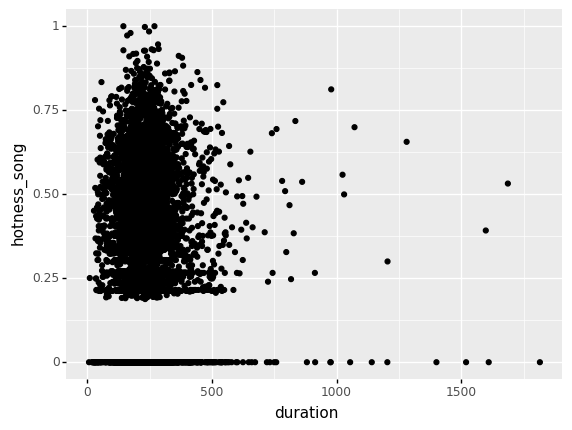

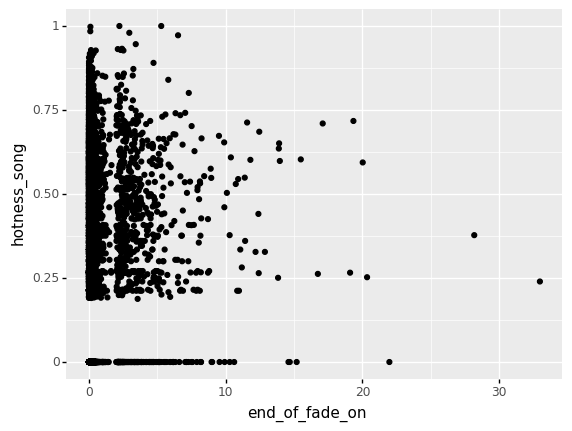

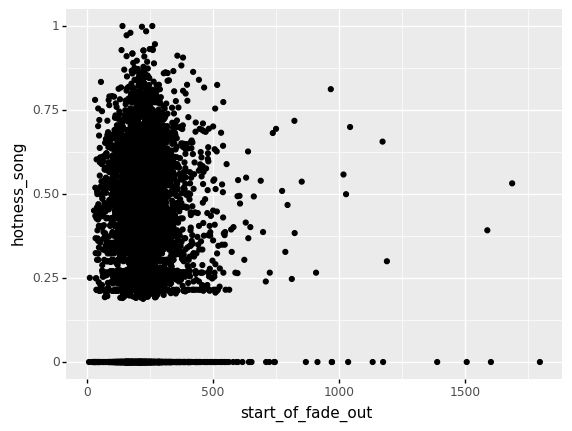

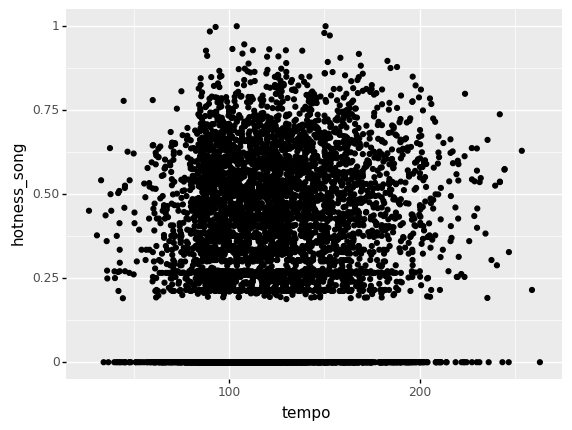

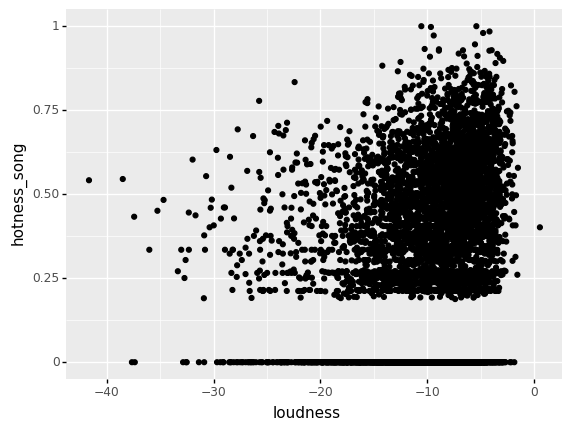

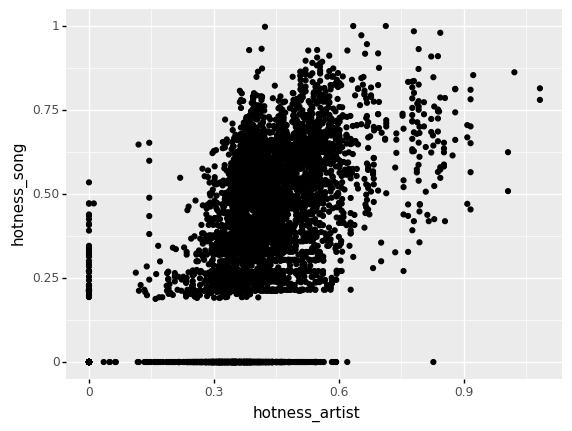

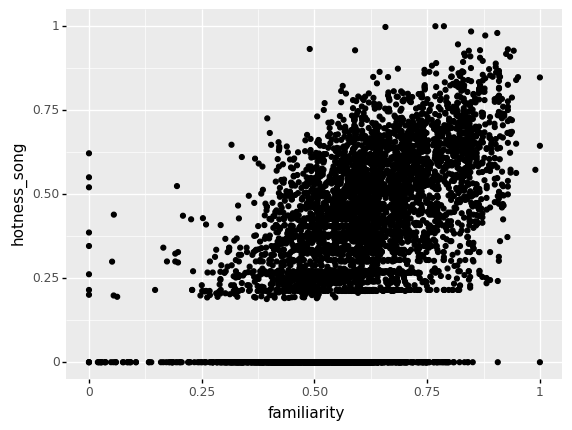

In [37]:
for col in numerical_features:
    (ggplot(data.select(col, target).toPandas(), aes(x = col, y = target)) + geom_point()).draw()

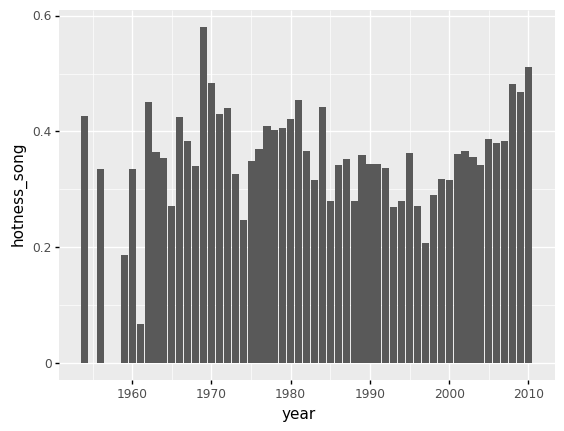

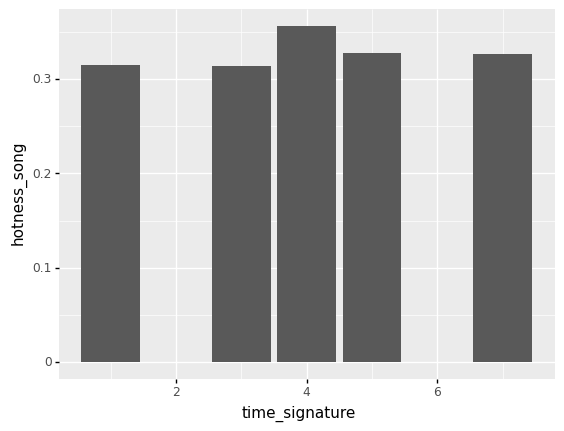

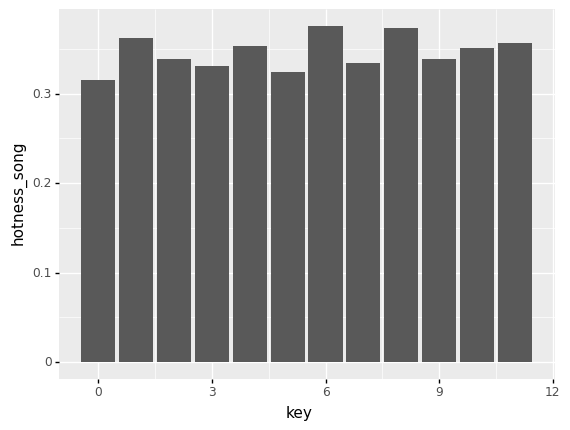

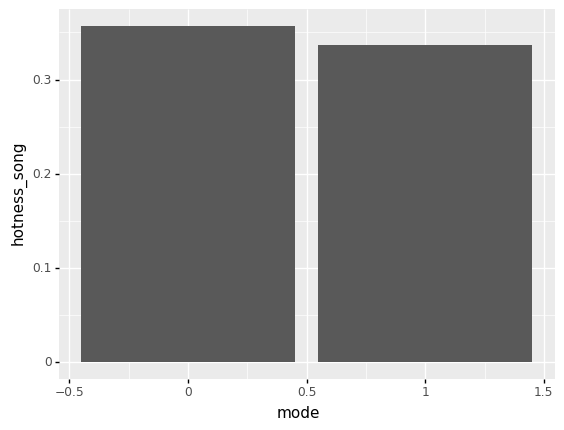

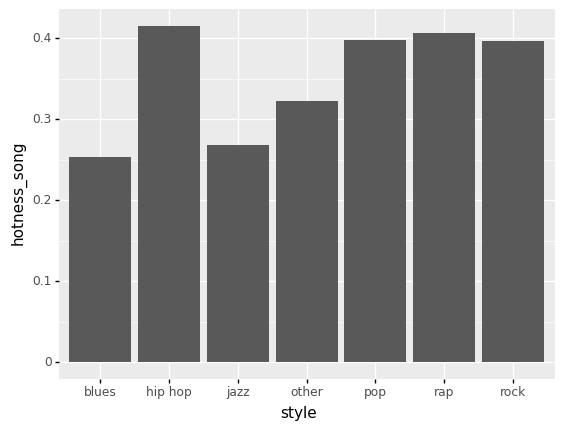

In [38]:
for col in categorical_feaures:
    col_data = data.groupBy(col).agg(F.mean(target).alias('hotness_song'))
    col_data = col_data.orderBy(col_data.hotness_song.desc())
    (ggplot(col_data.toPandas(), aes(x=col, y=target)) + geom_bar(stat='identity')).draw()

Viendo todas las gráficas parece que no existe ninguna relación clara directa entre la variable objetivo y el resto. Además, podemos ver que la variable objetivo acumula puntos para su valor 0.

Procedemos a hacer la matriz de correlaciones:

In [39]:
data_assembled = VectorAssembler(inputCols=features[:-1] + ['hotness_song'], outputCol='features')
corr_df = data_assembled.transform(data)
correlations = Correlation.corr(corr_df, 'features')
pd.DataFrame(correlations.first()[0].toArray(), index = features[:-1] + ['hotness_song'], columns=features[:-1] + ['hotness_song'])

/home/mdsuser/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


,year,duration,end_of_fade_on,start_of_fade_out,tempo,time_signature,key,loudness,mode,hotness_artist,familiarity,hotness_song
year,1.000000,0.032290,-0.000792,0.034209,0.015755,0.096607,0.019636,0.237480,-0.098625,0.056501,0.097566,0.076445
duration,0.032290,1.000000,0.097875,0.998286,-0.015287,0.112258,0.012694,0.020765,-0.043280,-0.009709,-0.000743,0.007077
end_of_fade_on,-0.000792,0.097875,1.000000,0.093376,-0.023886,0.011887,-0.009549,-0.097618,-0.003215,-0.007369,-0.018394,0.001654
start_of_fade_out,0.034209,0.998286,0.093376,1.000000,-0.012329,0.110767,0.012005,0.028086,-0.042790,-0.009480,0.000153,0.006153
tempo,0.015755,-0.015287,-0.023886,-0.012329,1.000000,0.028653,0.003311,0.173352,-0.026389,0.040628,0.058808,0.078996
time_signature,0.096607,0.112258,0.011887,0.110767,0.028653,1.000000,0.010253,0.100118,-0.064486,0.043349,0.060621,0.041856
key,0.019636,0.012694,-0.009549,0.012005,0.003311,0.010253,1.000000,0.063178,-0.174585,0.025340,0.040546,0.026078
loudness,0.237480,0.020765,-0.097618,0.028086,0.173352,0.100118,0.063178,1.000000,-0.045564,0.200509,0.257294,0.226922
mode,-0.098625,-0.043280,-0.003215,-0.042790,-0.026389,-0.064486,-0.174585,-0.045564,1.000000,-0.021135,-0.033321,-0.036753
hotness_artist,0.056501,-0.009709,-0.007369,-0.009480,0.040628,0.043349,0.025340,0.200509,-0.021135,1.000000,0.824169,0.521153


Viendo la matriz de correlaciones únicamente parece que tienen algo de correlación con hotness_song las variables hotness_artist y familiarity, ambas variables provenientes del artista.

## Regression

### Linear Regression

Lo primero que intentaremos hacer será una regresión lineal. Para ello lo primero que debemos hacer será dividir nuestro conjunto de datos en test y train.

Tras ello, haremos un OneHotEncoder con nuestra variable estilo y procederemos a entrenar el modelo con todas las variables y medir el rendimiento sobre train y test.

In [40]:
train, test = data.randomSplit([0.7, 0.3])

In [41]:
print(f'Número de observaciones en train: {train.count()}\nNúmero de observaciones en test: {test.count()}')

Número de observaciones en train: 3929
Número de observaciones en test: 1718


In [42]:
indexer = StringIndexer(inputCols = ['style'], outputCols = ['style_ind'])

In [43]:
encoder = OneHotEncoder(inputCols = ['style_ind'], outputCols = ['style_enc']) 

In [44]:
columns = [col for col in data.columns if col not in ['style', 'style_ind', target]]
assembler = VectorAssembler(inputCols=columns, outputCol='features')

In [45]:
lr = LinearRegression(featuresCol='features',
                      labelCol=target,
                      predictionCol='prediction',
                      regParam=0,
                      elasticNetParam=0,
                      fitIntercept=True,
                      standardization=False
                     )

In [46]:
pipeline = Pipeline(stages=[indexer, encoder, assembler, lr])

In [47]:
trained_pipeline = pipeline.fit(train)

22/04/09 15:10:04 WARN Instrumentation: [7a3666f5] regParam is zero, which might cause numerical instability and overfitting.


Observamos los coeficientes de nuestro modelo y sus p-valores.

In [48]:
linear_regression = trained_pipeline.stages[-1]
coefs = list(linear_regression.coefficients.toArray()) + [linear_regression.intercept]
pvalues = linear_regression.summary.pValues

pd.DataFrame({
    'features': columns + ['intercept'],
    'coefs': coefs,
    'pvalues': pvalues
})

,features,coefs,pvalues
0,year,0.000337,3.565021e-01
1,duration,0.001637,8.841779e-04
2,end_of_fade_on,0.001031,5.827989e-01
3,start_of_fade_out,-0.001642,1.026804e-03
4,tempo,0.000276,3.717788e-03
5,time_signature,-0.000206,9.388280e-01
6,key,-0.000253,7.840543e-01
7,loudness,0.004008,6.401658e-09
8,mode,-0.003713,6.044876e-01
9,hotness_artist,0.374586,2.220446e-16


In [49]:
train_preds = trained_pipeline.transform(train)
test_preds = trained_pipeline.transform(test)

In [50]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=target)

Vemos el error que hemos obtenido con nuestro modelo:

In [51]:
print(f"R2 para train: {evaluator.evaluate(train_preds, {evaluator.metricName: 'r2'})}\tMAE para train: {evaluator.evaluate(train_preds, {evaluator.metricName: 'mae'})}")
print(f"R2 para test: {evaluator.evaluate(test_preds, {evaluator.metricName: 'r2'})}\tMAE para test: {evaluator.evaluate(test_preds, {evaluator.metricName: 'mae'})}")

R2 para train: 0.32588775935408953	MAE para train: 0.1664805027925067


R2 para test: 0.33196232290005656	MAE para test: 0.16830624793125165


Como el dataset es pequeño podemos traer a memoria los resultados y el target para comparar gráficamente las predicciones de nuestro modelo con los valores reales:

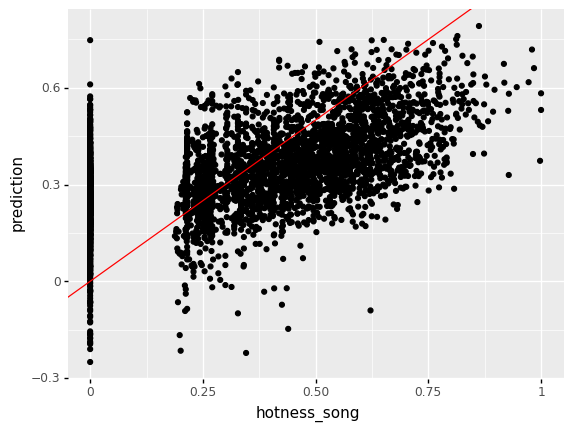

<ggplot: (8756191148641)>

In [52]:
train_results = train_preds.select(target, 'prediction').toPandas()
( 
ggplot(train_results, aes(x=target, y='prediction')) + 
    geom_point() + 
    geom_abline(slope=1, intercept=0, colour='red')
)

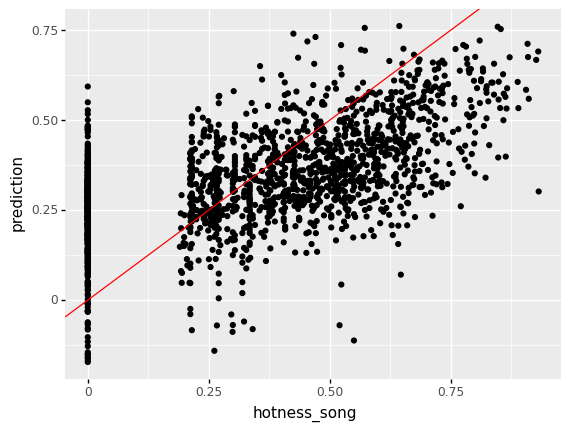

<ggplot: (8756190999929)>

In [53]:
test_results = test_preds.select(target, 'prediction').toPandas()
( 
ggplot(test_results, aes(x=target, y='prediction')) + 
    geom_point() + 
    geom_abline(slope=1, intercept=0, colour='red')
)

Vemos como el nivel de acierto es mínimo y sobre todo, como fallamos con observaciones cuyo hotness_song es ≈ 0.

### Random Forest

Vamos a probar con un Random Forest a ver si podemos mejorar nuestro resultado anterior.

Haremos un RandomForest con 100 árboles y determinados parámetros, y al igual que antes, entrenaremos y evaluaremos nuestro modelo.

In [54]:
rf = RandomForestRegressor(
    featuresCol='features', 
    labelCol=target, 
    predictionCol='prediction', 
    numTrees=100,
    maxDepth=8,
    minInstancesPerNode=5
)

In [55]:
pipeline_rf = Pipeline(stages=[indexer, encoder, assembler, rf])

In [56]:
trained_pipeline_rf = pipeline_rf.fit(train)

22/04/09 15:10:47 WARN DAGScheduler: Broadcasting large task binary with size 1212.5 KiB
22/04/09 15:10:48 WARN DAGScheduler: Broadcasting large task binary with size 2034.5 KiB
22/04/09 15:10:50 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


In [57]:
train_preds_rf = trained_pipeline_rf.transform(train)
test_preds_rf = trained_pipeline_rf.transform(test)

Con nuestro Random Forest obtenemos los siguientes errores:

In [58]:
print(f"R2 para train: {evaluator.evaluate(train_preds_rf, {evaluator.metricName: 'r2'})}\tMAE para train: {evaluator.evaluate(train_preds_rf, {evaluator.metricName: 'mae'})}")
print(f"R2 para test: {evaluator.evaluate(test_preds_rf, {evaluator.metricName: 'r2'})}\tMAE para test: {evaluator.evaluate(test_preds_rf, {evaluator.metricName: 'mae'})}")

R2 para train: 0.5148301132986346	MAE para train: 0.14089966887172256


R2 para test: 0.3639030332798938	MAE para test: 0.16494340674692456


Mejoramos algo los resultados obetenidos con la regresión lineal.

Volvemos a comparar las predicciones de nuestro modelo con los valores reales:

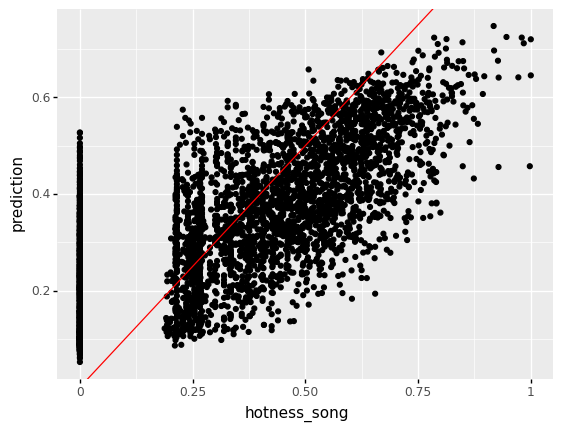

<ggplot: (8756270168802)>

In [59]:
train_results_rf = train_preds_rf.select(target, 'prediction').toPandas()
( 
ggplot(train_results_rf, aes(x=target, y='prediction')) + 
    geom_point() + 
    geom_abline(slope=1, intercept=0, colour='red')
)

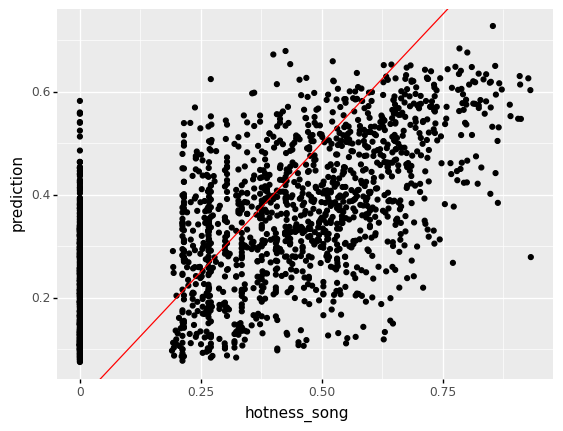

<ggplot: (8756190997511)>

In [60]:
test_results_rf = test_preds_rf.select(target, 'prediction').toPandas()
( 
ggplot(test_results_rf, aes(x=target, y='prediction')) + 
    geom_point() + 
    geom_abline(slope=1, intercept=0, colour='red')
)

Al igual que antes, tenemos mínimo acierto sobre todo en valores cercanos a 0.

### Optimización de hiperparámetros

Vamos a intentar hacer optimización de hiperparámetros de nuestro RandomForest. Como crear todas las combinaciones posibles de los hiperparámetros deseados con ParamGridBuilder sería muy costoso vamos a copiar la clase RandomGridBuilder tomada de https://medium.com/storebrand-tech/random-search-in-spark-ml-5370dc908bd7 que nos permitirá hacer optimización de hiperparámetros con selección aleatoria. Además de ello, haremos Cross Validation para mejorar el entrenamiento de nuestro modelo.

In [61]:
class RandomGridBuilder: 
  '''Grid builder for random search. Sets up grids for use in CrossValidator in Spark using values randomly sampled from user-provided distributions.
  Distributions should be provided as lambda functions, so that the numbers are generated at call time.
  
  Parameters:
    num_models: Integer (Python) - number of models to generate hyperparameters for
    seed: Integer (Python) - seed (optional, default is None)
    
  Returns:
    param_map: list of parameter maps to use in cross validation.
    
  Example usage:
    from pyspark.ml.classification import LogisticRegression
    lr = LogisticRegression()
    paramGrid = RandomGridBuilder(2)\
               .addDistr(lr.regParam, lambda: np.random.rand()) \
               .addDistr(lr.maxIter, lambda : np.random.randint(10))\
               .build()
               
    Returns similar output as Spark ML class ParamGridBuilder and can be used in its place. The above paramGrid provides random hyperparameters for 2 models.
    '''
  
  def __init__(self, num_models, seed=None):
    self._param_grid = {}
    self.num_models = num_models
    self.seed = seed
    
  def addDistr(self, param, distr_generator):
    '''Add distribution based on dictionary generated by function passed to addDistr.'''
    
    if 'pyspark.ml.param.Param' in str(type(param)):
      self._param_grid[param] = distr_generator
    else:
      raise TypeError('param must be an instance of Param')

    return self
  
  def build(self):    
    param_map = []
    for n in range(self.num_models):
      if self.seed:
        # Set seeds for both numpy and random in case either is used for the random distribution
        np.random.seed(self.seed + n)
        np.random.seed(self.seed + n)
      param_dict = {}
      for param, distr in self._param_grid.items():
        param_dict[param] = distr()
      param_map.append(param_dict)
    
    return param_map

In [62]:
randomParams = RandomGridBuilder(3, 1)\
    .addDistr(rf.numTrees, lambda : np.random.choice([50, 100, 150])) \
    .addDistr(rf.maxDepth, lambda : np.random.choice([10, 12, 15])) \
    .addDistr(rf.minInstancesPerNode, lambda : np.random.choice([5, 10, 15])) \
    .build()

Vemos las distintas configuraciones que vamos a probar:

In [63]:
i=1
for conf in randomParams:
    print(f'Configuration {i}:')
    for param in conf:
        print(param, '->', conf[param])
    print()
    i+=1

Configuration 1:
RandomForestRegressor_1c76cca9584d__numTrees -> 100
RandomForestRegressor_1c76cca9584d__maxDepth -> 10
RandomForestRegressor_1c76cca9584d__minInstancesPerNode -> 5

Configuration 2:
RandomForestRegressor_1c76cca9584d__numTrees -> 50
RandomForestRegressor_1c76cca9584d__maxDepth -> 12
RandomForestRegressor_1c76cca9584d__minInstancesPerNode -> 5

Configuration 3:
RandomForestRegressor_1c76cca9584d__numTrees -> 150
RandomForestRegressor_1c76cca9584d__maxDepth -> 10
RandomForestRegressor_1c76cca9584d__minInstancesPerNode -> 10



Procedemos a hacer el CrossValidation y a entrenar el modelo:

In [64]:
cv = CrossValidator(estimator=rf, evaluator=evaluator, estimatorParamMaps=randomParams, numFolds=3)

In [65]:
pipeline_cv = Pipeline(stages=[indexer, encoder, assembler, cv])

In [66]:
trained_pipeline_cv = pipeline_cv.fit(train)

22/04/09 15:13:17 WARN DAGScheduler: Broadcasting large task binary with size 1345.7 KiB
22/04/09 15:13:38 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/04/09 15:14:06 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/04/09 15:14:45 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/04/09 15:15:34 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/04/09 15:16:10 WARN DAGScheduler: Broadcasting large task binary with size 1027.8 KiB
22/04/09 15:18:07 WARN DAGScheduler: Broadcasting large task binary with size 1273.3 KiB
22/04/09 15:18:25 WARN DAGScheduler: Broadcasting large task binary with size 1877.7 KiB
22/04/09 15:18:49 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/04/09 15:19:16 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/04/09 15:19:48 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/04/09 15:20:21 WARN DAGScheduler: Broad

Vemos cual es el mejor modelo:

In [67]:
print(trained_pipeline_cv.stages[-1].avgMetrics)
print(trained_pipeline_cv.stages[-1].bestModel)

[0.19910499828601597, 0.2001605163851942, 0.19887231291368648]
RandomForestRegressionModel: uid=RandomForestRegressor_1c76cca9584d, numTrees=150, numFeatures=11


Parece que el mejor ha sido el que utiliza 150 árboles. Hacemos predicciones y vemos resultados:

In [68]:
train_preds_cv = trained_pipeline_cv.transform(train)
test_preds_cv = trained_pipeline_cv.transform(test)

In [69]:
print(f"R2 para train: {evaluator.evaluate(train_preds_cv, {evaluator.metricName: 'r2'})}\tMAE para train: {evaluator.evaluate(train_preds_cv, {evaluator.metricName: 'mae'})}")
print(f"R2 para test: {evaluator.evaluate(test_preds_cv, {evaluator.metricName: 'r2'})}\tMAE para test: {evaluator.evaluate(test_preds_cv, {evaluator.metricName: 'mae'})}")

R2 para train: 0.5551949842041008	MAE para train: 0.1346190771985209


R2 para test: 0.3693192391877158	MAE para test: 0.16420394677049216


Más o menos tenemos los mismos resultados que con el RandomForest sin optimizar (es cierto que únicamente hemos probado 3 posibles combinaciones de hiperparámetros).

Hacemos los plots:

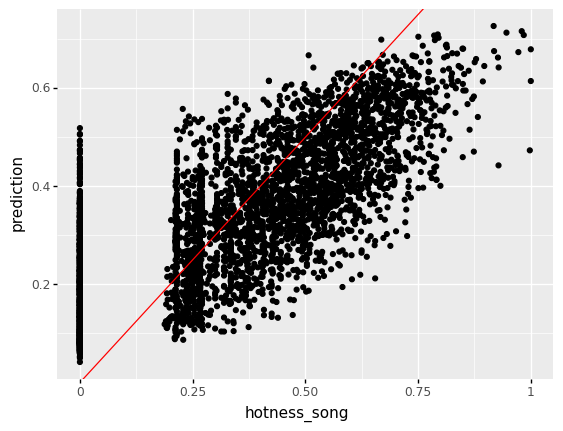

<ggplot: (8756191148581)>

In [70]:
train_results_cv = train_preds_cv.select(target, 'prediction').toPandas()
( 
ggplot(train_results_cv, aes(x=target, y='prediction')) + 
    geom_point() + 
    geom_abline(slope=1, intercept=0, colour='red')
)

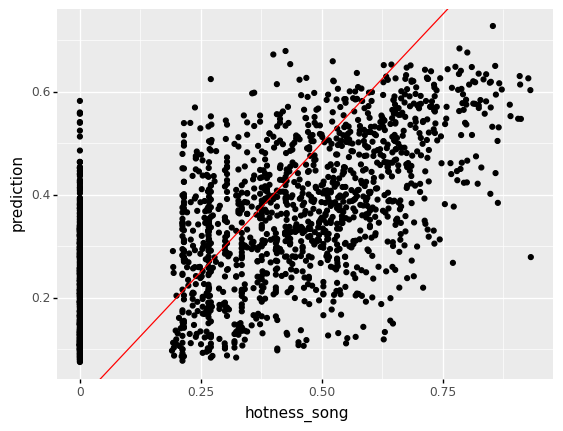

<ggplot: (8756196051601)>

In [71]:
test_results_cv = test_preds_rf.select(target, 'prediction').toPandas()
( 
ggplot(test_results_cv, aes(x=target, y='prediction')) + 
    geom_point() + 
    geom_abline(slope=1, intercept=0, colour='red')
)

Las gráficas son similares al resto de modelos que hemos probado. 

Siempre vemos como los valores de 0 nos provocan grandes errores, así que vamos a ver que resultados tendría nuestro modelo sin estos valores. Utilizamos el modelo que mejores resultados había obtenido:

22/04/09 16:34:48 WARN DAGScheduler: Broadcasting large task binary with size 1596.1 KiB
22/04/09 16:34:49 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/04/09 16:34:51 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/04/09 16:34:53 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/04/09 16:34:57 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


R2 para train: 0.5279174700014817	MAE para train: 0.0926222679249747


R2 para test: 0.3117066560732731	MAE para test: 0.11640132074032991


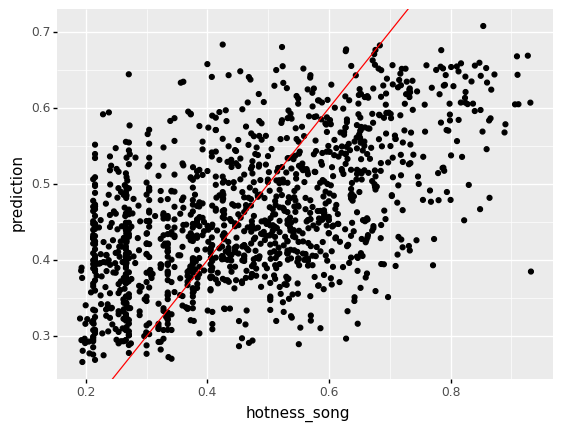

<ggplot: (8756191262952)>

In [73]:
train_zero = train.where(train.hotness_song != 0)
test_zero = test.where(test.hotness_song != 0)

rf_zero = RandomForestRegressor(
    featuresCol='features', 
    labelCol=target, 
    predictionCol='prediction', 
    numTrees=150,
    maxDepth=10,
    minInstancesPerNode=10
)

pipeline_zero = Pipeline(stages=[indexer, encoder, assembler, rf_zero])

trained_pipeline_zero = pipeline_zero.fit(train_zero)

train_preds_zero = trained_pipeline_zero.transform(train_zero)
test_preds_zero = trained_pipeline_zero.transform(test_zero)

print(f"R2 para train: {evaluator.evaluate(train_preds_zero, {evaluator.metricName: 'r2'})}\tMAE para train: {evaluator.evaluate(train_preds_zero, {evaluator.metricName: 'mae'})}")
print(f"R2 para test: {evaluator.evaluate(test_preds_zero, {evaluator.metricName: 'r2'})}\tMAE para test: {evaluator.evaluate(test_preds_zero, {evaluator.metricName: 'mae'})}")

test_results_zero = test_preds_zero.select(target, 'prediction').toPandas()
( 
ggplot(test_results_zero, aes(x=target, y='prediction')) + 
    geom_point() + 
    geom_abline(slope=1, intercept=0, colour='red')
)

Vemos como obtenemos peor R2, aunque es verdad que obtenemos un mejor MAE.

## Close session

In [74]:
spark.stop()